In [1]:
import os
from abc import ABC, abstractmethod
from collections import Counter
from typing import Any, Type, override

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from medmnist import INFO
from medmnist.dataset import BloodMNIST, DermaMNIST, MedMNIST2D
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, Subset
from torchmetrics.functional import accuracy, f1_score, precision, recall, roc
from torchvision.models import resnet50
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
from torchvision.utils import make_grid


In [2]:
class DatasetWrapper:
    def __init__(
        self,
        dataset_class: Type[MedMNIST2D],
        size: int,
        save_dir: str,
        transform: Compose | None = None,
        balance: bool = False,
    ):
        self.dataset_class = dataset_class
        self.size = size
        self.save_dir = save_dir
        self.transform = transform

        os.makedirs(save_dir, exist_ok=True)
        self.datasets = {
            "train": self._load_dataset(split="train"),
            "val": self._load_dataset(split="val"),
            "test": self._load_dataset(split="test"),
        }

        if balance:
            self.datasets["train"] = self.get_balanced_train_dataset()

    @property
    def name(self) -> str:
        return self.dataset_class.__name__

    @property
    def labels(self) -> dict[str, int]:
        return INFO[self.dataset_class.flag]["label"]

    def get_dataloaders(
        self, batch_size: int
    ) -> dict[str, torch.utils.data.DataLoader]:
        return {
            "train": torch.utils.data.DataLoader(
                self.datasets["train"],
                batch_size=batch_size,
                shuffle=True,
                num_workers=4,
            ),
            "val": torch.utils.data.DataLoader(
                self.datasets["val"],
                batch_size=batch_size,
                shuffle=False,
                num_workers=4,
            ),
            "test": torch.utils.data.DataLoader(
                self.datasets["test"],
                batch_size=batch_size,
                shuffle=False,
                num_workers=4,
            ),
        }

    def visualize(self, num_samples_each_class: int = 1) -> None:
        num_classes = len(self.labels)
        total_cols = num_samples_each_class + 1
        fig = plt.figure(figsize=(total_cols * 3, num_classes * 3))

        for class_idx in range(num_classes):
            ax = fig.add_subplot(num_classes, total_cols, class_idx * total_cols + 1)
            ax.text(
                0.5,
                0.5,
                f"{class_idx} - {self.labels[str(class_idx)][:20]}",
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=12,
            )
            ax.axis("off")

            samples = [
                sample for sample in self.datasets["train"] if sample[1] == class_idx
            ][:num_samples_each_class]

            for sample_idx, sample in enumerate(samples):
                image = sample[0].numpy().transpose(1, 2, 0)
                ax = fig.add_subplot(
                    num_classes, total_cols, class_idx * total_cols + sample_idx + 2
                )
                ax.imshow(image, interpolation="nearest")
                ax.axis("off")
        fig.tight_layout()
        plt.show()

    def get_balanced_train_dataset(self) -> Dataset:
        """
        Zwraca zbalansowany zbiór treningowy, w którym każda klasa ma równą liczbę próbek.
        Liczba próbek na klasę jest równa liczbie próbek w najbardziej licznej klasie (oversampling).
        """
        train_dataset = self.datasets["train"]
        num_classes = len(self.labels)

        # Debugowanie: Sprawdź rozmiar oryginalnego datasetu
        print(f"Original train dataset length: {len(train_dataset)}")
        
        # Pobierz dane i etykiety, debugując ich rozmiary
        data_samples = []
        labels = []
        for i, sample in enumerate(train_dataset):
            data, label = sample
            data_samples.append(data)
            labels.append(label.item() if hasattr(label, 'item') else label)
            if i < 5:  # Drukuj tylko первые 5 próbek dla czytelności
                print(f"Sample {i}: data shape: {data.shape}, label: {label}, label type: {type(label)}")
        
        labels = np.array(labels)
        print(f"Labels array shape: {labels.shape}, unique labels: {np.unique(labels)}")

        # Policz próbki dla każdej klasy
        class_counts = np.bincount(labels, minlength=num_classes)
        print(f"Class counts: {class_counts}")

        # Znajdź maksymalną liczbę próbek wśród wszystkich klas
        max_samples = np.max(class_counts)
        print(f"Max samples per class: {max_samples}")

        if max_samples == 0:
            raise ValueError("Zbiór treningowy jest pusty.")

        # Zbierz indeksy dla każdej klasy
        class_indices = [np.where(labels == i)[0] for i in range(num_classes)]
        for i, indices in enumerate(class_indices):
            print(f"Class {i}: {len(indices)} samples, indices sample: {indices[:5]}")

        # Losowo duplikuj próbki, aby każda klasa miała `max_samples` próbek
        balanced_indices = []
        for i, indices in enumerate(class_indices):
            if len(indices) == 0:
                raise ValueError(
                    f"Klasa {self.labels[str(i)]} nie ma próbek w zbiorze treningowym."
                )
            current_count = len(indices)
            if current_count < max_samples:
                # Losowo wybieraj dodatkowe indeksy z powtórzeniami
                extra_indices = np.random.choice(
                    indices, size=max_samples - current_count, replace=True
                )
                balanced_indices.extend(np.concatenate([indices, extra_indices]))
            else:
                balanced_indices.extend(indices)
            print(f"Class {i} balanced: {len(balanced_indices) - len(indices) + current_count} samples")

        # Debugowanie: Sprawdź rozmiar balanced_indices
        print(f"Total balanced indices: {len(balanced_indices)}")

        # Stwórz podzbiór zbioru treningowego z wybranymi indeksami
        balanced_dataset = Subset(train_dataset, balanced_indices)

        # Debugowanie: Sprawdź kilka próbek z balanced_dataset
        print(f"Balanced dataset length: {len(balanced_dataset)}")
        for i in range(min(5, len(balanced_dataset))):
            data, label = balanced_dataset[i]
            print(f"Balanced sample {i}: data shape: {data.shape}, label: {label}")

        return balanced_dataset

    def _load_dataset(self, split: str) -> Dataset:
        return self.dataset_class(
            split=split,
            download=True,
            size=self.size,
            root=self.save_dir,
            transform=self.transform,
        )

    def __getitem__(self, key: str) -> Dataset:
        if key not in self.datasets:
            raise KeyError(
                f"Dataset {key} not found. Available keys: {list(self.datasets.keys())}"
            )
        return self.datasets[key]


In [3]:
data_transform = Compose([
    ToTensor(),
])

datasets = {
    "blood": DatasetWrapper(BloodMNIST, size=64, save_dir="data", transform=data_transform, balance=True),
    "derma": DatasetWrapper(DermaMNIST, size=64, save_dir="data", transform=data_transform, balance=True),
}


Original train dataset length: 11959
Sample 0: data shape: torch.Size([3, 64, 64]), label: [7], label type: <class 'numpy.ndarray'>
Sample 1: data shape: torch.Size([3, 64, 64]), label: [3], label type: <class 'numpy.ndarray'>
Sample 2: data shape: torch.Size([3, 64, 64]), label: [6], label type: <class 'numpy.ndarray'>
Sample 3: data shape: torch.Size([3, 64, 64]), label: [6], label type: <class 'numpy.ndarray'>
Sample 4: data shape: torch.Size([3, 64, 64]), label: [7], label type: <class 'numpy.ndarray'>
Labels array shape: (11959,), unique labels: [0 1 2 3 4 5 6 7]
Class counts: [ 852 2181 1085 2026  849  993 2330 1643]
Max samples per class: 2330
Class 0: 852 samples, indices sample: [26 38 42 47 79]
Class 1: 2181 samples, indices sample: [10 11 19 21 32]
Class 2: 1085 samples, indices sample: [ 6  7  9 17 31]
Class 3: 2026 samples, indices sample: [ 1 15 30 41 46]
Class 4: 849 samples, indices sample: [28 37 39 52 53]
Class 5: 993 samples, indices sample: [22 23 29 45 49]
Class 6:

In [4]:
# for name in datasets:
#     dataset = datasets[name]  # Wybierz zbiór danych
#     dataloader = dataset.get_dataloaders(batch_size=1)["train"]

#     # Zbierz wszystkie etykiety
#     class_counts = Counter()
#     for _, labels in dataloader:
#         class_counts.update(labels.tolist()[0])

#     print(f"Class {name} counts:", class_counts)


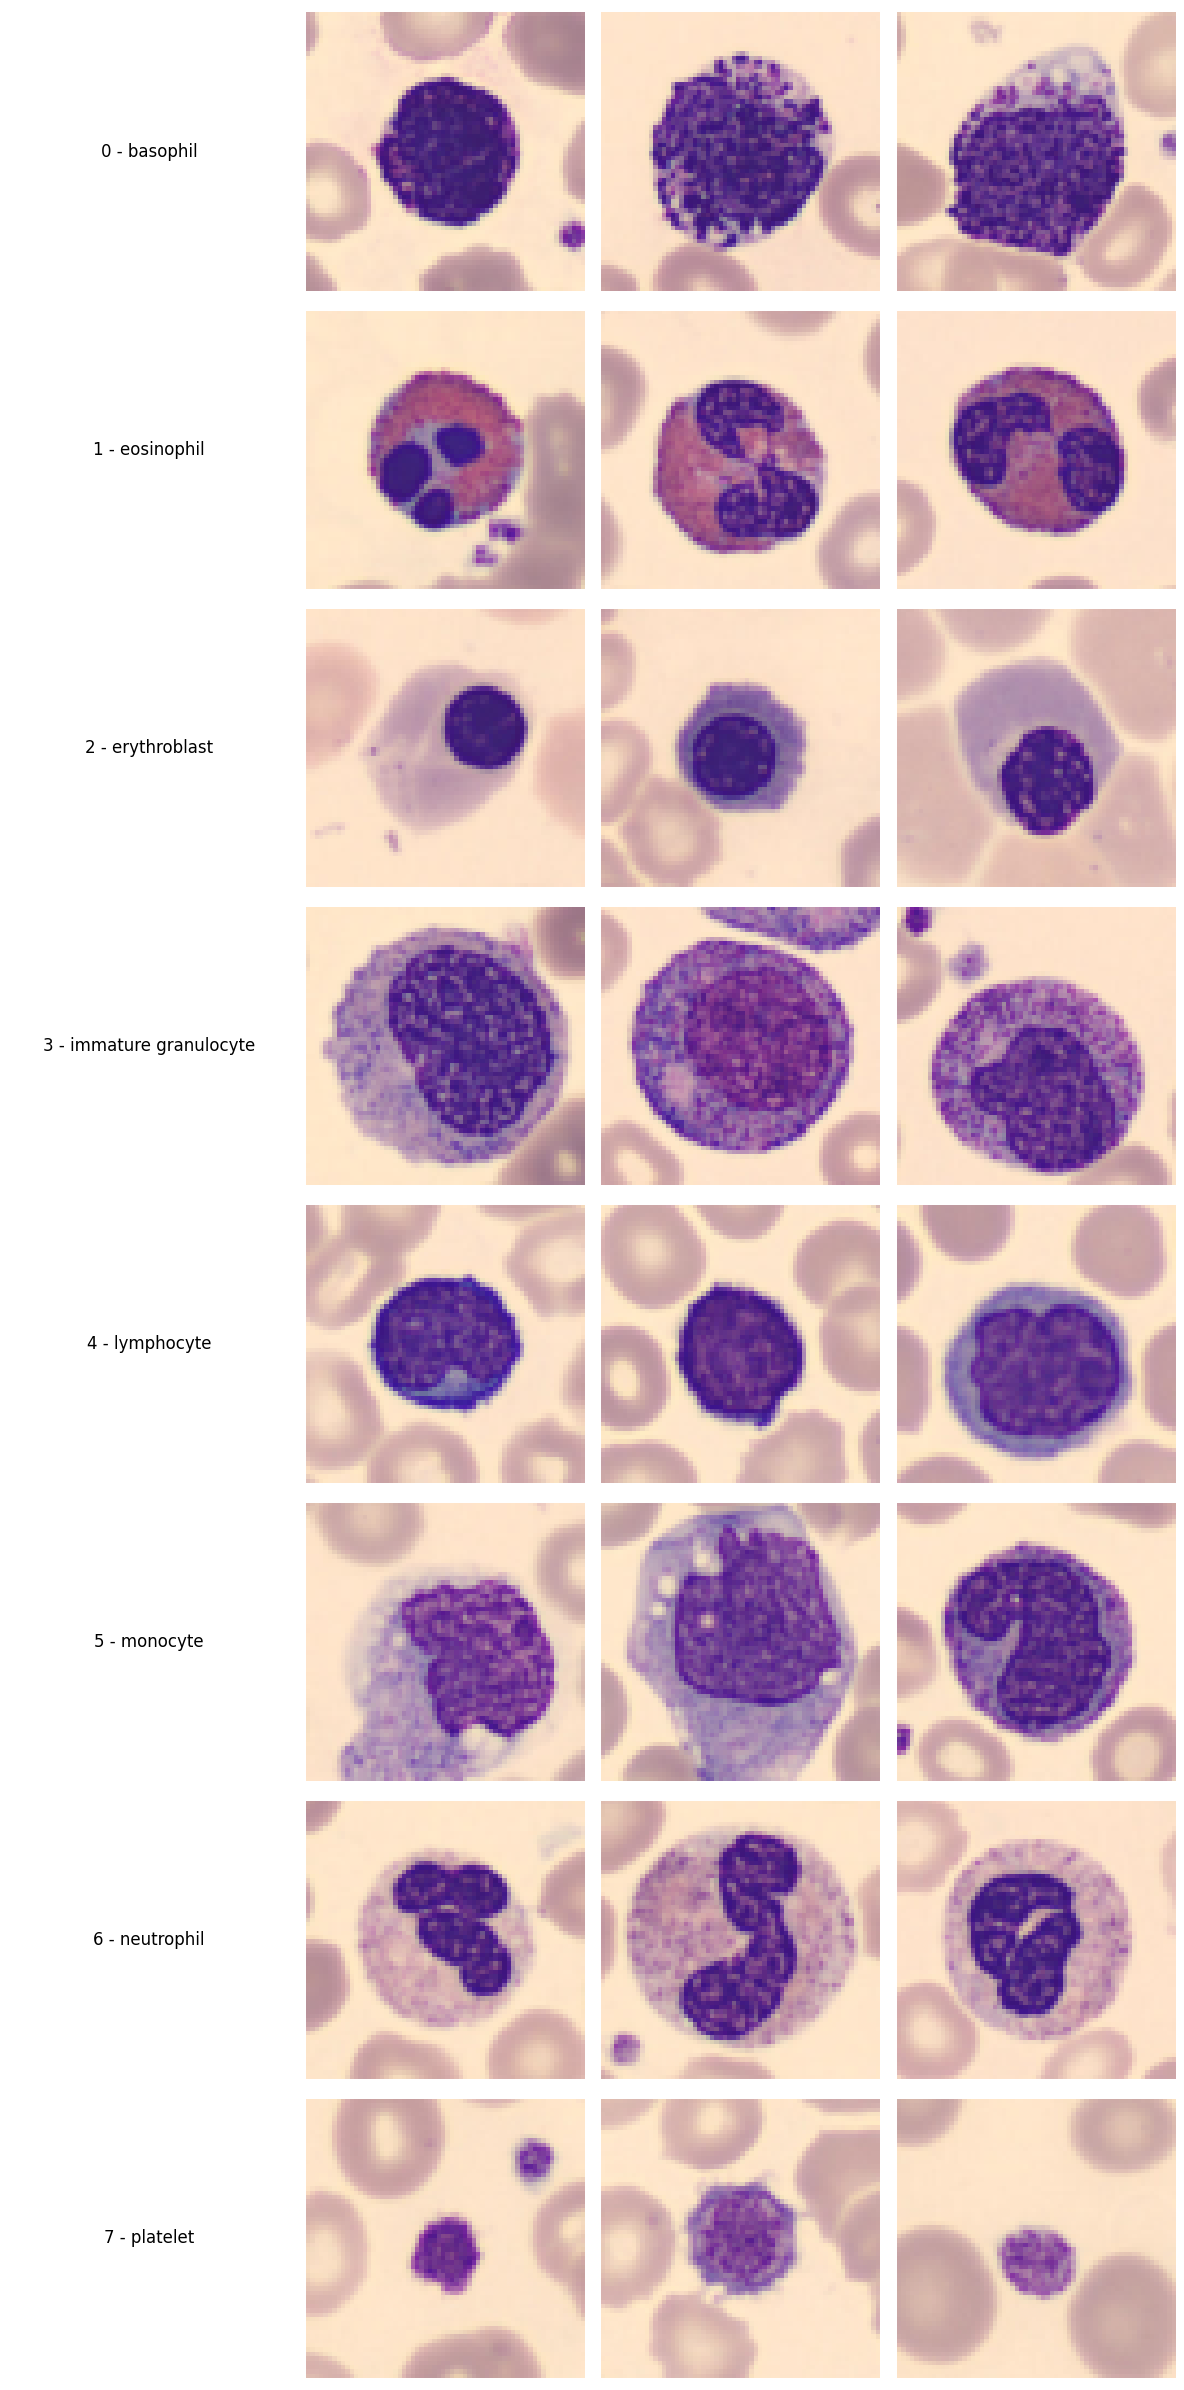

In [5]:
datasets["blood"].visualize(num_samples_each_class=3)


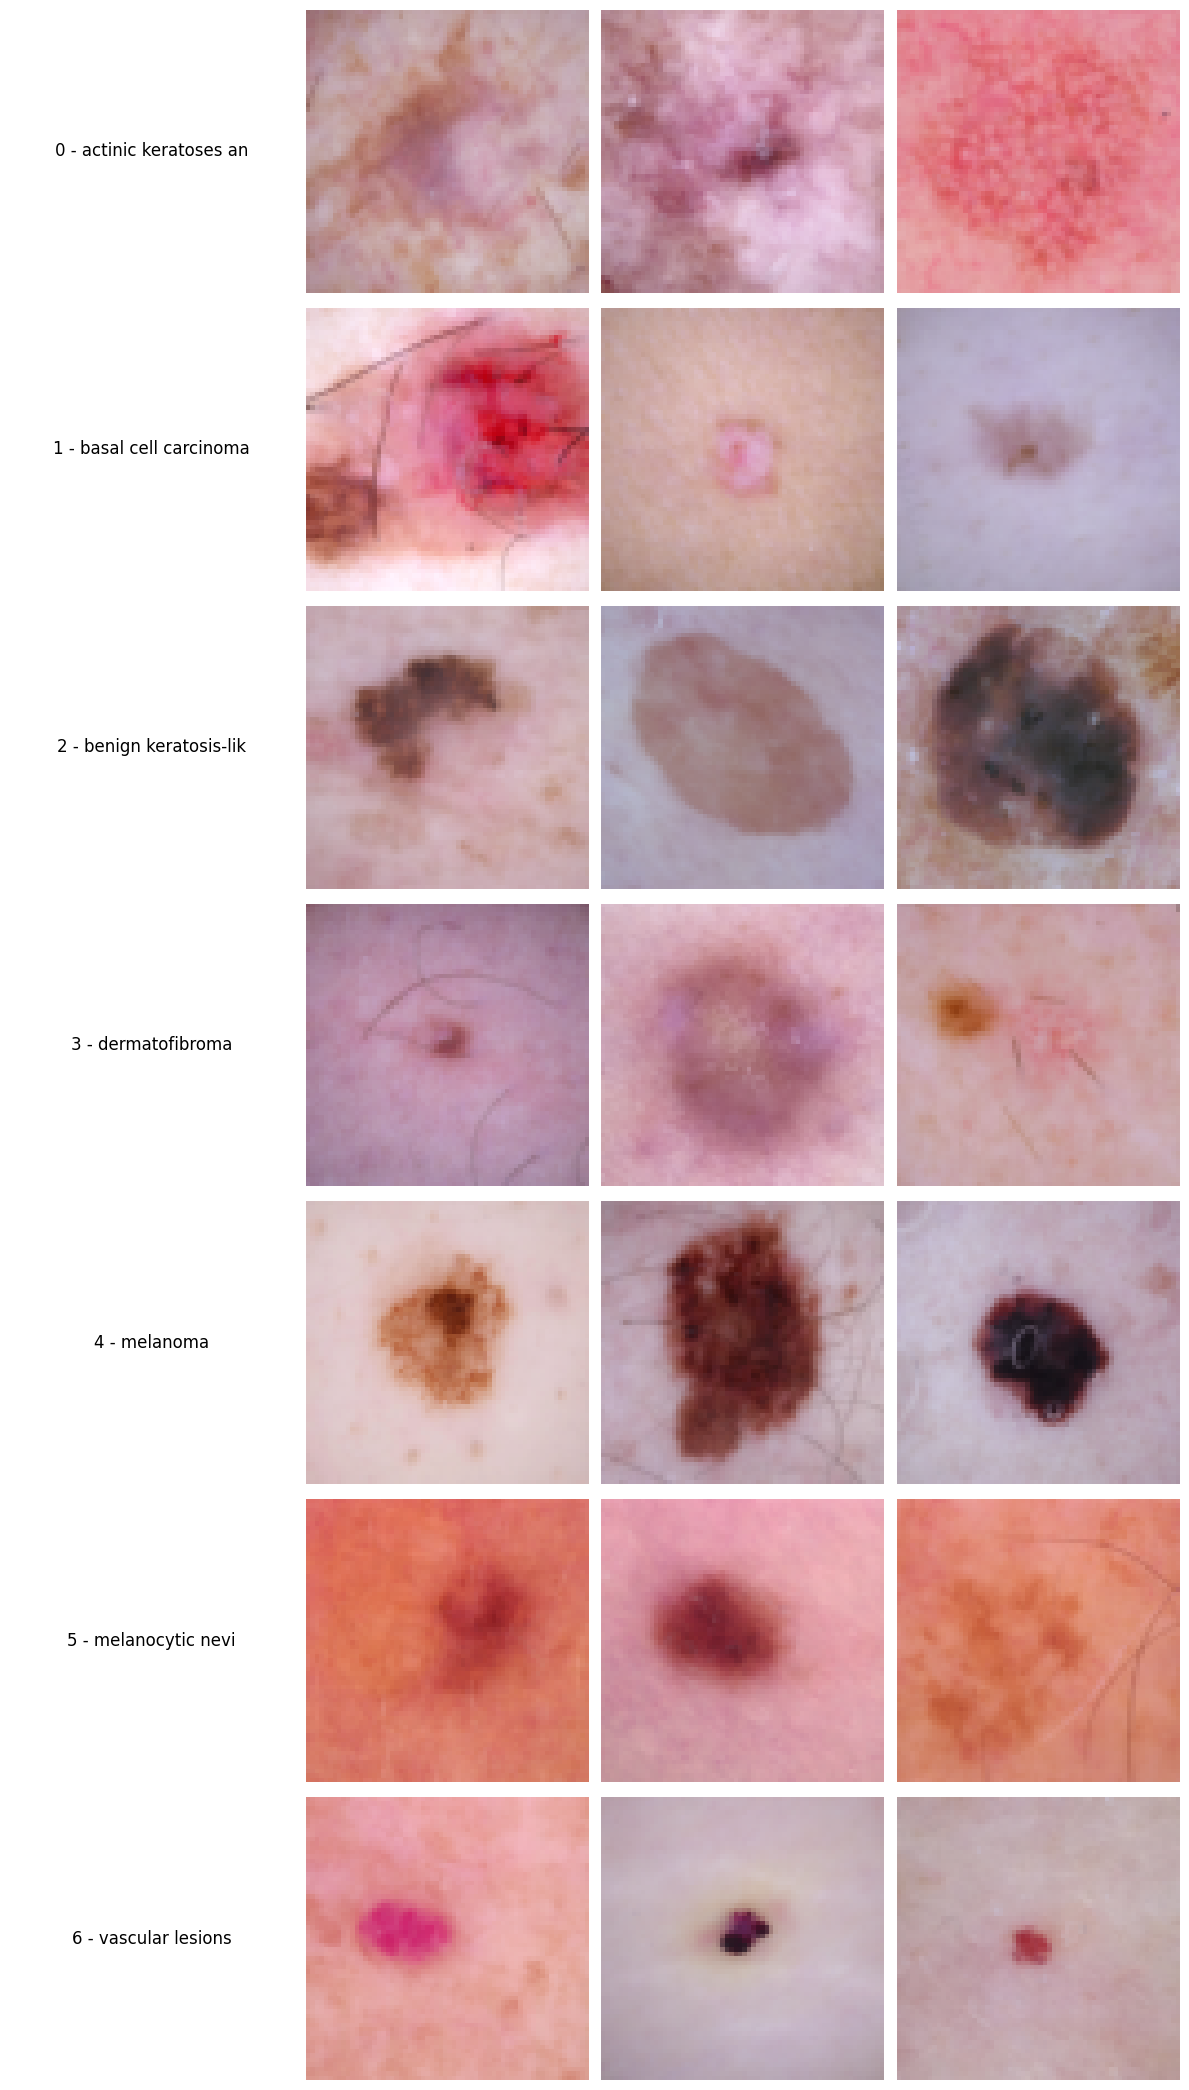

In [6]:
datasets["derma"].visualize(num_samples_each_class=3)


In [7]:
class Classifier(nn.Module):
    WEIGHTS_NAME = "IMAGENET1K_V2"

    def __init__(self, num_classes: int, weights_dir: str = "weights", *args, **kwargs):
        super(Classifier, self).__init__(*args, **kwargs)
        os.makedirs(weights_dir, exist_ok=True)
        weights_file = os.path.join(weights_dir, "resnet50.pth")
        if os.path.exists(weights_file):
            self._resnet = resnet50(weights=None)
            state_dict = torch.load(weights_file, weights_only=True)
            self._resnet.load_state_dict(state_dict)
            print(f"Wczytano wagi z pliku: {weights_file}")
        else:
            print(f"Pobieranie wag {self.WEIGHTS_NAME} i zapis do: {weights_file}")
            self._resnet = resnet50(weights=self.WEIGHTS_NAME)
            torch.save(
                self._resnet.state_dict(),
                weights_file,
            )
            print(f"Zapisano wagi do pliku: {weights_file}")
            self._resnet.fc = nn.Linear(self._resnet.fc.in_features, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        return self._resnet(x)


In [8]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.utils import make_grid


class Generator(nn.Module):
    def __init__(self, latent_dim, img_size, num_classes):
        super().__init__()
        self.img_size = img_size
        self.num_channels = 3
        self.label_embedding = nn.Embedding(num_classes, 50)

        self.init_size = img_size // 4  # Dla upsamplingu
        self.l1 = nn.Linear(latent_dim + 50, 128 * self.init_size * self.init_size)
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, self.num_channels, 3, stride=1, padding=1),
            nn.Tanh(),  # Użyj Tanh dla [-1, 1]
        )

    def forward(self, z, labels):
        c = self.label_embedding(labels)
        z = torch.cat((z, c), dim=1)
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self, img_size, num_classes):
        super().__init__()
        self.img_size = img_size
        self.num_channels = 3
        self.label_embedding = nn.Embedding(num_classes, 50)

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(self.num_channels, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
        )
        ds_size = img_size // 4
        self.fc = nn.Sequential(
            nn.Linear(128 * ds_size * ds_size + 50, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, labels):
        c = self.label_embedding(labels)
        out = self.conv_blocks(x)
        out = out.view(out.shape[0], -1)
        out = torch.cat((out, c), dim=1)
        return self.fc(out).squeeze()


class GANTrainer:
    def __init__(
        self,
        generator: Generator,
        discriminator: Discriminator,
        g_optimizer: torch.optim.Optimizer,
        d_optimizer: torch.optim.Optimizer,
        criterion: nn.Module,
        z_size: int,
        num_classes: int,
        device: torch.device,
    ):
        self.generator = generator
        self.discriminator = discriminator
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.criterion = criterion
        self.z_size = z_size
        self.num_classes = num_classes
        self.device = device

    def generator_train_step(self, batch_size: int) -> torch.Tensor:
        self.g_optimizer.zero_grad()

        z = torch.randn(batch_size, self.z_size, device=self.device)
        fake_labels = torch.randint(
            0, self.num_classes, (batch_size,), device=self.device
        )

        fake_images = self.generator(z, fake_labels)
        validity = self.discriminator(fake_images, fake_labels)

        g_loss = self.criterion(validity, torch.ones(batch_size, device=self.device))
        g_loss.backward()
        self.g_optimizer.step()

        return g_loss.detach()

    def discriminator_train_step(
        self, real_images: torch.Tensor, labels: torch.Tensor
    ) -> torch.Tensor:
        batch_size = len(real_images)
        self.d_optimizer.zero_grad()

        # Train with real images
        real_validity = self.discriminator(real_images, labels)
        real_loss = self.criterion(
            real_validity, torch.ones(batch_size, device=self.device)
        )

        # Train with fake images
        z = torch.randn(batch_size, self.z_size, device=self.device)
        fake_labels = torch.randint(
            0, self.num_classes, (batch_size,), device=self.device
        )
        fake_images = self.generator(z, fake_labels)

        fake_validity = self.discriminator(fake_images.detach(), fake_labels)
        fake_loss = self.criterion(
            fake_validity, torch.zeros(batch_size, device=self.device)
        )

        d_loss = real_loss + fake_loss
        d_loss.backward()
        self.d_optimizer.step()

        return d_loss.detach(), real_validity.mean().item(), fake_validity.mean().item()

    def train(
        self,
        epochs: int,
        data_loader: torch.utils.data.DataLoader,
        print_every: int = 1,
    ):
        for epoch in range(epochs):
            self.generator.train()
            self.discriminator.train()

            g_loss_total = 0.0
            d_loss_total = 0.0
            batches = 0

            for batch_idx, (real_images, labels) in enumerate(data_loader):
                print(f"Batch {batch_idx + 1}/{len(data_loader)}")
                real_images = real_images.to(self.device)
                labels = labels.to(self.device)

                d_loss, real_validity, fake_validity = self.discriminator_train_step(
                    real_images, labels.squeeze()
                )
                for _ in range(2):  # Dwa kroki generatora na jeden krok dyskryminatora
                    g_loss = self.generator_train_step(batch_size=len(real_images))

                g_loss_total += g_loss.item()
                d_loss_total += d_loss.item()
                batches += 1

            if (epoch + 1) % print_every == 0:
                avg_g_loss = g_loss_total / batches
                avg_d_loss = d_loss_total / batches
                print(
                    f"Epoch [{epoch + 1}/{epochs}] - G Loss: {avg_g_loss:.4f}, D Loss: {avg_d_loss:.4f}, D(x): {real_validity:.4f}, D(G(z)): {fake_validity:.4f}"
                )

                # Generate sample images
                self.generator.eval()
                with torch.no_grad():
                    z = torch.randn(self.num_classes, self.z_size, device=self.device)
                    sample_labels = torch.arange(self.num_classes, device=self.device)
                    sample_images = self.generator(z, sample_labels).cpu()

                # No need to unsqueeze since we already have 3 channels
                grid = (
                    make_grid(sample_images, nrow=4, normalize=True)
                    .permute(1, 2, 0)
                    .numpy()
                )
                plt.imshow(grid)
                plt.axis("off")
                plt.show()


Batch 1/129
Batch 2/129
Batch 3/129
Batch 4/129
Batch 5/129
Batch 6/129
Batch 7/129
Batch 8/129
Batch 9/129
Batch 10/129
Batch 11/129
Batch 12/129
Batch 13/129
Batch 14/129
Batch 15/129
Batch 16/129
Batch 17/129
Batch 18/129
Batch 19/129
Batch 20/129
Batch 21/129
Batch 22/129
Batch 23/129
Batch 24/129
Batch 25/129
Batch 26/129
Batch 27/129
Batch 28/129
Batch 29/129
Batch 30/129
Batch 31/129
Batch 32/129
Batch 33/129
Batch 34/129
Batch 35/129
Batch 36/129
Batch 37/129
Batch 38/129
Batch 39/129
Batch 40/129
Batch 41/129
Batch 42/129
Batch 43/129
Batch 44/129
Batch 45/129
Batch 46/129
Batch 47/129
Batch 48/129
Batch 49/129
Batch 50/129
Batch 51/129
Batch 52/129
Batch 53/129
Batch 54/129
Batch 55/129
Batch 56/129
Batch 57/129
Batch 58/129
Batch 59/129
Batch 60/129
Batch 61/129
Batch 62/129
Batch 63/129
Batch 64/129
Batch 65/129
Batch 66/129
Batch 67/129
Batch 68/129
Batch 69/129
Batch 70/129
Batch 71/129
Batch 72/129
Batch 73/129
Batch 74/129
Batch 75/129
Batch 76/129
Batch 77/129
Batch 78

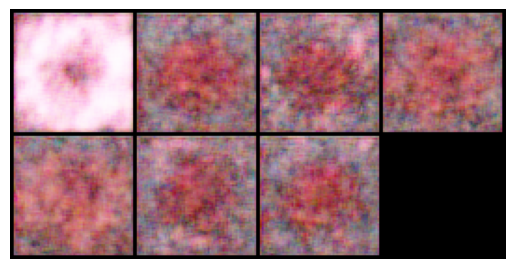

Batch 1/129
Batch 2/129
Batch 3/129
Batch 4/129
Batch 5/129
Batch 6/129
Batch 7/129
Batch 8/129
Batch 9/129
Batch 10/129
Batch 11/129
Batch 12/129
Batch 13/129
Batch 14/129
Batch 15/129
Batch 16/129
Batch 17/129
Batch 18/129
Batch 19/129
Batch 20/129
Batch 21/129
Batch 22/129
Batch 23/129
Batch 24/129
Batch 25/129
Batch 26/129
Batch 27/129
Batch 28/129
Batch 29/129
Batch 30/129
Batch 31/129
Batch 32/129
Batch 33/129
Batch 34/129
Batch 35/129
Batch 36/129
Batch 37/129
Batch 38/129
Batch 39/129
Batch 40/129
Batch 41/129
Batch 42/129
Batch 43/129
Batch 44/129
Batch 45/129
Batch 46/129
Batch 47/129
Batch 48/129
Batch 49/129
Batch 50/129
Batch 51/129
Batch 52/129
Batch 53/129
Batch 54/129
Batch 55/129
Batch 56/129
Batch 57/129
Batch 58/129
Batch 59/129
Batch 60/129
Batch 61/129
Batch 62/129
Batch 63/129
Batch 64/129
Batch 65/129
Batch 66/129
Batch 67/129
Batch 68/129
Batch 69/129
Batch 70/129
Batch 71/129
Batch 72/129
Batch 73/129
Batch 74/129
Batch 75/129
Batch 76/129
Batch 77/129
Batch 78

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = datasets["derma"]

# Hyperparameters
latent_dim = 256
img_size = 64  # Example for MNIST-like data
num_classes = len(dataset.labels)
batch_size = 256
epochs = 500

# Initialize models
generator = Generator(latent_dim, img_size, num_classes).to(device)
discriminator = Discriminator(img_size, num_classes).to(device)

# Optimizers and loss
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# Initialize trainer
trainer = GANTrainer(
    generator=generator,
    discriminator=discriminator,
    g_optimizer=g_optimizer,
    d_optimizer=d_optimizer,
    criterion=criterion,
    z_size=latent_dim,
    num_classes=num_classes,
    device=device,
)

trainer.train(
    epochs=epochs,
    data_loader=dataset.get_dataloaders(batch_size)["train"],
    print_every=1,
)


In [ ]:
import json
from collections import defaultdict
from dataclasses import asdict, dataclass


@dataclass
class Result:
    loss: float
    accuracy: float
    precision: float
    f1_score: float
    recall: float
    roc: float


class Results:
    def __init__(self):
        self._results = defaultdict(list)

    def update(self, mode: str, result: Result):
        self._results[mode].append(result)

    def to_json(self, filename: str) -> None:
        results_dict = {
            mode: [asdict(result) for result in results]
            for mode, results in self._results.items()
        }

        with open(filename, "w") as file:
            json.dump(results_dict, file, indent=4)

    def to_dict_of_lists(self):
        return {
            mode: {
                "loss": [result.loss for result in results],
                "accuracy": [result.accuracy for result in results],
                "precision": [result.precision for result in results],
                "f1_score": [result.f1_score for result in results],
                "recall": [result.recall for result in results],
                "roc": [result.roc for result in results],
            }
            for mode, results in self._results.items()
        }


In [ ]:
class Experiment(ABC):
    NAME = None
    METRICS = [
        accuracy,
        f1_score,
        precision,
        recall,
        roc,
    ]

    def __init__(
        self,
        dataset: DatasetWrapper,
        fake_data_generator: FakeDataGenerator,
        config: dict[str, Any],
    ):
        self._dataset = dataset
        self._fake_data_generator = fake_data_generator
        self._config = config

        self._classifier = Classifier(num_classes=len(dataset.labels))
        self._results = Results()

    def run(self):
        self._train_classifier()
        self._print_summary()
        self._show_plots()
        self._save_results()
        self._test_classifier()
        return self._results

    def _train_classifier(self):
        train_dataset = self._get_train_data()
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self._config["batch_size"],
            shuffle=True,
            num_workers=4,
        )
        val_dataset = self._get_val_data()
        val_dataloader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=self._config["batch_size"],
            shuffle=False,
            num_workers=4,
        )
        optim = torch.optim.Adam(
            self._classifier.parameters(),
            lr=self._config["learning_rate"],
        )
        criterion = nn.CrossEntropyLoss()

        self._classifier.train()
        self._classifier.to(self._config["device"])

        for epoch in range(1, self._config["epochs"]):
            epoch_loss = 0.0
            for batch_idx, (data, target) in enumerate(train_dataloader):
                data = data.to(self._config["device"])
                target = target.to(self._config["device"])

                optim.zero_grad()
                output = self._classifier(data)
                loss = criterion(output, target)
                loss.backward()
                optim.step()
                epoch_loss += loss.item()
        self._results.update("train", self._evaluate_classifier(train_dataloader))
        self._results.update("valid", self._evaluate_classifier(val_dataloader))

    def _evaluate_classifier(self, dataloader: DataLoader):
        self._classifier.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []

        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for data, target in dataloader:
                data = data.to(self._config["device"])
                target = target.to(self._config["device"])

                output = self._classifier(data)
                loss = criterion(output, target)
                val_loss += loss.item()

                _, preds = torch.max(output, 1)
                all_preds.append(preds.cpu().numpy())
                all_targets.append(target.cpu().numpy())

        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)

        return Result(
            loss=val_loss / len(dataloader),
            accuracy=accuracy(all_preds, all_targets),
            f1_score=f1_score(all_preds, all_targets),
            precision=precision(all_preds, all_targets),
            recall=recall(all_preds, all_targets),
            roc=roc(all_preds, all_targets),
        )

    def _test_classifier(self):
        test_dataset = self._get_test_data()
        test_dataloader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=self._config["batch_size"],
            shuffle=False,
            num_workers=4,
        )
        self._results.update("test", self._evaluate_classifier(test_dataloader))

    def _print_summary(self):
        print(f"Podsumowanie eksperymentu: {self.NAME}")
        print(f"Zbiór danych: {self._dataset.name}")
        print(f"Wyniki: {self._results['test']}")

    def _show_plots(self):
        pass

    def _save_results(self):
        short_name = self.__class__.__name__
        self._results.save(
            os.path.join(
                self._config["results_dir"],
                f"{short_name}_{self._dataset.name}.json",
            )
        )

    def __str__(self):
        return f"{self.NAME} - Zbiór danych: {self._dataset.name}"

    @abstractmethod
    def _get_train_data(self):
        pass

    @abstractmethod
    def get_val_data(self):
        pass

    @abstractmethod
    def _get_test_data(self):
        pass


class OriginalTrainFakeTest(Experiment):
    NAME = "Klasyfikator trenowany na danych oryginalnych, testowany na wygenerowanych"

    def __init__(
        self,
        dataset: DatasetWrapper,
        fake_data_generator: FakeDataGenerator,
        config: dict[str, Any],
    ):
        super().__init__(dataset, fake_data_generator, config)

    @override
    def _get_train_data(self):
        return self._dataset["train"]

    @override
    def get_val_data(self):
        return self._dataset["val"]

    @override
    def _get_test_data(self):
        num_samples = len(self._dataset["test"])
        return self._fake_data_generator.generate_data(num_samples)


class FakeTrainOriginalTest(Experiment):
    NAME = "Klasyfikator trenowany na danych wygenerowanych, testowany na oryginalnych"

    def __init__(
        self,
        dataset: DatasetWrapper,
        fake_data_generator: FakeDataGenerator,
        config: dict[str, Any],
    ):
        super().__init__(dataset, fake_data_generator, config)

    @override
    def _get_train_data(self):
        num_samples = len(self._dataset["train"])
        return self._fake_data_generator.generate_data(num_samples)

    @override
    def get_val_data(self):
        num_samples = len(self._dataset["val"])
        return self._fake_data_generator.generate_data(num_samples)

    @override
    def _get_test_data(self):
        return self._dataset["test"]


class MixTrainMixTest(Experiment):
    NAME = "Klasyfikator trenowany i testowany na połączeniu dwóch zbiorów z odpowiednim ich podziałem"

    def __init__(
        self,
        dataset: DatasetWrapper,
        fake_data_generator: FakeDataGenerator,
        config: dict[str, Any],
    ):
        super().__init__(dataset, fake_data_generator, config)

    @override
    def _get_train_data(self):
        pass

    @override
    def get_val_data(self):
        pass

    @override
    def _get_test_data(self):
        pass
